# ECG Classification Dataset Generation

## Part 0: Config & Imports

In [70]:
from pathlib import Path
from typing import Dict, List, Tuple

import wfdb
import numpy as np
from tqdm import tqdm
from scipy.signal import resample_poly

In [71]:
# --------------------
# Global config
# --------------------
TARGET_FS = 500  # must match your pretraining if you want to reuse FM encoder
BEAT_SEC = 0.6  # length of single beat segment in seconds (can adjust)
WIN_SEC = 5  # window length for 5s windows
WIN_STRIDE_SEC = 5  # non-overlapping 5s windows for window-level task

DATA_ROOT = Path(r"../data")  # TODO: adjust to your path
MITDB_DIR = DATA_ROOT / "mitdb"
OUT_ROOT = DATA_ROOT / "downstream_mitdb"  # output dir for downstream datasets
OUT_ROOT.mkdir(parents=True, exist_ok=True)

print("MITDB_DIR:", MITDB_DIR)
print("OUT_ROOT:", OUT_ROOT)

MITDB_DIR: ..\data\mitdb
OUT_ROOT: ..\data\downstream_mitdb


## Part 1: AAMI label mapping (beat symbol -> AAMI class)

In [72]:
# AAMI superclasses: N, S, V, F, Q
AAMI_CLASSES = ["N", "S", "V", "F", "Q"]
AAMI_TO_INDEX: Dict[str, int] = {c: i for i, c in enumerate(AAMI_CLASSES)}


# Mapping from MIT-BIH beat symbol to AAMI superclass
# Adjust this mapping according to your previous decisions / references
MITDB_SYMBOL_TO_AAMI: Dict[str, str] = {
    # Normal beats -> N
    "N": "N",
    "L": "N",
    "R": "N",
    # Left/right bundle branch block
    "B": "N",
    "e": "N",
    "J": "N",
    # Atrial/aberrated/suprventricular -> S
    "A": "S",
    "a": "S",
    # "J": "S",
    "S": "S",
    # Premature ventricular contractions -> V
    "V": "V",
    "E": "V",
    # Fusion of ventricular and normal -> F
    "F": "F",
    # Unknown / paced / etc. -> Q
    "/": "Q",
    "Q": "Q",
    "P": "Q",  # example, adjust as needed
    # You can add more symbols here based on your exact mapping
}


def map_symbol_to_aami(symbol: str) -> str | None:
    """
    Map a MIT-BIH beat symbol to an AAMI superclass.
    Return None if the symbol should be ignored.
    """
    return MITDB_SYMBOL_TO_AAMI.get(symbol, None)


def aami_to_index(aami: str) -> int:
    return AAMI_TO_INDEX[aami]

## Part 2: Resampling & Beat annotation loading

In [73]:
def resample_signal(sig: np.ndarray, fs_orig: int, fs_target: int) -> np.ndarray:
    """
    Resample a 1D signal from fs_orig to fs_target using polyphase resampling.
    """
    if fs_orig == fs_target:
        return sig.astype(np.float32)

    up = fs_target
    down = fs_orig
    sig_res = resample_poly(sig, up, down)
    return sig_res.astype(np.float32)


def zscore_1d(x: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    """
    Simple z-score normalization for a 1D array.
    """
    mean = x.mean()
    std = x.std()
    if std < eps:
        std = 1.0
    return ((x - mean) / std).astype(np.float32)


def read_mitdb_record(rec_path: Path) -> Tuple[np.ndarray, int]:
    """
    Read a MIT-BIH record and return:
        - single lead signal as 1D float32 array
        - original sampling rate fs_orig

    We focus on MLII / V5 / V1, similar to pretraining.
    """
    rec = wfdb.rdrecord(str(rec_path))
    sig = rec.p_signal  # [T, n_sig]
    sig_names = rec.sig_name
    fs_orig = int(rec.fs)

    # Prefer MLII, then II, then V1, then fallback channel 0
    name_to_idx = {name: idx for idx, name in enumerate(sig_names)}
    if "MLII" in name_to_idx:
        idx = name_to_idx["MLII"]
    elif "II" in name_to_idx:
        idx = name_to_idx["II"]
    elif "V1" in name_to_idx:
        idx = name_to_idx["V1"]
    else:
        idx = 0

    sig_1d = sig[:, idx].astype(np.float32).reshape(-1)
    return sig_1d, fs_orig


def read_mitdb_annotations(rec_path: Path) -> Tuple[np.ndarray, List[str]]:
    """
    Read beat annotations for a MIT-BIH record.

    Returns:
        ann_samples: np.ndarray of sample indices (original sampling rate)
        symbols: list of beat symbols
    """
    # MIT-BIH annotations are typically in .atr files
    ann = wfdb.rdann(str(rec_path), "atr")
    ann_samples = ann.sample.astype(int)
    symbols = list(ann.symbol)
    return ann_samples, symbols

### Part 3: Beat-level dataset (Single Beat segments)

对每个 record：

- 读取信号 (`sig_orig`) 和 `fs_orig`
- 重采样到 `TARGET_FS` → sig_res
- 读取 beat annotation (`ann_samples`, `symbols`)
- 同样把 beat 位置按比例映射到新采样率
- 对每一个 beat：
    - 映射 symbol → AAMI 类别（`map_symbol_to_aami`，跳过 None）
    - 以 beat 为中心截取 `BEAT_SEC` 长度的片段，如果超出边界就跳过
    - 对该片段做 `z-score`

最终得到：

- `beats_X`: `[N_beats, L_beat]`
- `beats_y`: `[N_beats]`（int64）

In [74]:
def build_mitdb_beat_level(
    mitdb_dir: Path,
    out_dir: Path,
    target_fs: int = TARGET_FS,
    beat_sec: float = BEAT_SEC,
) -> None:
    """
    Build beat-level classification dataset from MIT-BIH.

    Outputs:
        mitdb_beat_X.npy: [N_beats, L_beat]
        mitdb_beat_y.npy: [N_beats]
    """
    out_dir.mkdir(parents=True, exist_ok=True)

    hea_files = sorted(mitdb_dir.rglob("*.hea"))
    if not hea_files:
        raise FileNotFoundError(f"No .hea files found in {mitdb_dir}")

    beat_half_len = int(target_fs * beat_sec / 2.0)
    beat_len = beat_half_len * 2  # even length around center

    all_beats = []
    all_labels = []

    for hea in tqdm(hea_files, desc="MITDB beat-level"):
        rec_path = hea.with_suffix("")  # without extension

        try:
            sig_orig, fs_orig = read_mitdb_record(rec_path)
            ann_samples, symbols = read_mitdb_annotations(rec_path)
        except Exception as e:
            print(f"[WARN] Failed to read {rec_path}: {e}")
            continue

        # Resample signal
        sig_res = resample_signal(sig_orig, fs_orig, target_fs)
        T_res = len(sig_res)

        # Map annotation positions to resampled indices
        # (simple ratio, ok for our purpose)
        factor = target_fs / fs_orig
        ann_res = (ann_samples.astype(float) * factor).round().astype(int)

        for sample_idx, sym in zip(ann_res, symbols):
            aami = map_symbol_to_aami(sym)
            if aami is None:
                # ignore symbols we do not want to classify
                continue

            center = int(sample_idx)
            start = center - beat_half_len
            end = center + beat_half_len

            # Skip beats too close to boundaries
            if start < 0 or end > T_res:
                continue

            seg = sig_res[start:end]  # [beat_len]
            seg = zscore_1d(seg)  # z-score
            all_beats.append(seg)
            all_labels.append(aami_to_index(aami))

    if not all_beats:
        raise RuntimeError("No beats collected for MIT-BIH beat-level dataset.")

    X = np.stack(all_beats, axis=0)  # [N_beats, L_beat]
    y = np.array(all_labels, dtype=np.int64)  # [N_beats]

    x_path = out_dir / "mitdb_beat_X.npy"
    y_path = out_dir / "mitdb_beat_y.npy"
    np.save(x_path, X.astype(np.float32))
    np.save(y_path, y)

    print("Beat-level dataset saved:")
    print("  X:", x_path, X.shape, X.dtype)
    print("  y:", y_path, y.shape, y.dtype)

## Part 4: 5s Beat-centered window dataset

基本和 beat-level 一样，只是：

- 每个样本不再是短 beat 片段，而是 5s window：
    - 长度：WIN_SEC * TARGET_FS
    - 中心：beat 位置
- label 仍然是中心 beat 的 AAMI 类别

边界检查：如果 5s 窗口越界，跳过该 beat

In [75]:
def build_mitdb_center5s(
    mitdb_dir: Path,
    out_dir: Path,
    target_fs: int = TARGET_FS,
    win_sec: float = WIN_SEC,
) -> None:
    """
    Build beat-centered 5s window classification dataset from MIT-BIH.

    Outputs:
        mitdb_center5s_X.npy: [N, L_win]
        mitdb_center5s_y.npy: [N]
    """
    out_dir.mkdir(parents=True, exist_ok=True)

    hea_files = sorted(mitdb_dir.rglob("*.hea"))
    if not hea_files:
        raise FileNotFoundError(f"No .hea files found in {mitdb_dir}")

    win_len = int(target_fs * win_sec)
    half_len = win_len // 2

    all_wins = []
    all_labels = []

    for hea in tqdm(hea_files, desc="MITDB 5s-center"):
        rec_path = hea.with_suffix("")

        try:
            sig_orig, fs_orig = read_mitdb_record(rec_path)
            ann_samples, symbols = read_mitdb_annotations(rec_path)
        except Exception as e:
            print(f"[WARN] Failed to read {rec_path}: {e}")
            continue

        sig_res = resample_signal(sig_orig, fs_orig, target_fs)
        T_res = len(sig_res)

        factor = target_fs / fs_orig
        ann_res = (ann_samples.astype(float) * factor).round().astype(int)

        for sample_idx, sym in zip(ann_res, symbols):
            aami = map_symbol_to_aami(sym)
            if aami is None:
                continue

            center = int(sample_idx)
            start = center - half_len
            end = center + half_len

            if start < 0 or end > T_res:
                continue

            win = sig_res[start:end]  # [win_len]
            win = zscore_1d(win)  # per-window z-score
            all_wins.append(win)
            all_labels.append(aami_to_index(aami))

    if not all_wins:
        raise RuntimeError("No windows collected for MIT-BIH 5s-center dataset.")

    X = np.stack(all_wins, axis=0)  # [N, L_win]
    y = np.array(all_labels, dtype=np.int64)

    x_path = out_dir / "mitdb_center5s_X.npy"
    y_path = out_dir / "mitdb_center5s_y.npy"
    np.save(x_path, X.astype(np.float32))
    np.save(y_path, y)

    print("5s-center dataset saved:")
    print("  X:", x_path, X.shape, X.dtype)
    print("  y:", y_path, y.shape, y.dtype)

## Part 5: 5s window-level dataset (majority label)

这里我们不再「按 beat 来切」，而是：

对重采样后的整个记录按 5s 非重叠分段：`0~5s, 5~10s, 10~15s, ...`

对每个 5s window：

- 找到所有落在这个 window 内的 beat（用 `ann_res`）
- 每个 beat 有一个 AAMI 类别
- 统计 AAMI 频数，选出现最多的作为 label（majority vote）
- 如果某个 window 内没有任何 “有效 AAMI beat”，就丢弃
- `z-score` 这个 window

输出：

- `mitdb_win5s_X.npy`, 
- `mitdb_win5s_y.npy`

In [76]:
from collections import Counter


def build_mitdb_win5s(
    mitdb_dir: Path,
    out_dir: Path,
    target_fs: int = TARGET_FS,
    win_sec: float = WIN_SEC,
    stride_sec: float = WIN_STRIDE_SEC,
) -> None:
    """
    Build 5s window-level classification dataset from MIT-BIH.

    Window label is defined by majority AAMI class of beats within the window.
    Windows with no valid beats are discarded.

    Outputs:
        mitdb_win5s_X.npy: [N, L_win]
        mitdb_win5s_y.npy: [N]
    """
    out_dir.mkdir(parents=True, exist_ok=True)

    hea_files = sorted(mitdb_dir.rglob("*.hea"))
    if not hea_files:
        raise FileNotFoundError(f"No .hea files found in {mitdb_dir}")

    win_len = int(target_fs * win_sec)
    stride = int(target_fs * stride_sec)

    all_wins = []
    all_labels = []

    for hea in tqdm(hea_files, desc="MITDB 5s-window"):
        rec_path = hea.with_suffix("")

        try:
            sig_orig, fs_orig = read_mitdb_record(rec_path)
            ann_samples, symbols = read_mitdb_annotations(rec_path)
        except Exception as e:
            print(f"[WARN] Failed to read {rec_path}: {e}")
            continue

        sig_res = resample_signal(sig_orig, fs_orig, target_fs)
        T_res = len(sig_res)

        factor = target_fs / fs_orig
        ann_res = (ann_samples.astype(float) * factor).round().astype(int)

        # Pre-map all beats in this record to AAMI indices (or None)
        beat_positions: List[int] = []
        beat_labels: List[int] = []

        for sample_idx, sym in zip(ann_res, symbols):
            aami = map_symbol_to_aami(sym)
            if aami is None:
                continue
            pos = int(sample_idx)
            if pos < 0 or pos >= T_res:
                continue
            beat_positions.append(pos)
            beat_labels.append(aami_to_index(aami))

        if not beat_positions:
            continue

        beat_positions = np.array(beat_positions, dtype=int)
        beat_labels = np.array(beat_labels, dtype=int)

        # Slide non-overlapping 5s windows
        start = 0
        while start + win_len <= T_res:
            end = start + win_len

            # Find beats inside this window
            mask = (beat_positions >= start) & (beat_positions < end)
            if not np.any(mask):
                # No labeled beats in this window: skip
                start += stride
                continue

            labels_in_win = beat_labels[mask]
            # Majority vote
            counter = Counter(labels_in_win.tolist())
            majority_label, majority_count = counter.most_common(1)[0]

            win = sig_res[start:end]  # [win_len]
            win = zscore_1d(win)
            all_wins.append(win)
            all_labels.append(majority_label)

            start += stride

    if not all_wins:
        raise RuntimeError("No windows collected for MIT-BIH 5s-window dataset.")

    X = np.stack(all_wins, axis=0)
    y = np.array(all_labels, dtype=np.int64)

    x_path = out_dir / "mitdb_win5s_X.npy"
    y_path = out_dir / "mitdb_win5s_y.npy"
    np.save(x_path, X.astype(np.float32))
    np.save(y_path, y)

    print("5s-window dataset saved:")
    print("  X:", x_path, X.shape, X.dtype)
    print("  y:", y_path, y.shape, y.dtype)

## Part 6: Main entry (run all three builders)

In [77]:
# if __name__ == "__main__":
#     print("Building MIT-BIH downstream datasets...")

#     build_mitdb_beat_level(
#         mitdb_dir=MITDB_DIR,
#         out_dir=OUT_ROOT,
#         target_fs=TARGET_FS,
#         beat_sec=BEAT_SEC,
#     )

#     build_mitdb_center5s(
#         mitdb_dir=MITDB_DIR,
#         out_dir=OUT_ROOT,
#         target_fs=TARGET_FS,
#         win_sec=WIN_SEC,
#     )

#     build_mitdb_win5s(
#         mitdb_dir=MITDB_DIR,
#         out_dir=OUT_ROOT,
#         target_fs=TARGET_FS,
#         win_sec=WIN_SEC,
#         stride_sec=WIN_STRIDE_SEC,
#     )

#     print("All downstream datasets built.")

## Check

In [78]:
# Step 1 – Basic shape & dtype check

from pathlib import Path
import numpy as np

beat_X = np.load(OUT_ROOT / "mitdb_beat_X.npy")
beat_y = np.load(OUT_ROOT / "mitdb_beat_y.npy")

center_X = np.load(OUT_ROOT / "mitdb_center5s_X.npy")
center_y = np.load(OUT_ROOT / "mitdb_center5s_y.npy")

win_X = np.load(OUT_ROOT / "mitdb_win5s_X.npy")
win_y = np.load(OUT_ROOT / "mitdb_win5s_y.npy")

print("Beat-level:")
print("  X:", beat_X.shape, beat_X.dtype)
print("  y:", beat_y.shape, beat_y.dtype)

print("\n5s center:")
print("  X:", center_X.shape, center_X.dtype)
print("  y:", center_y.shape, center_y.dtype)

print("\n5s window-level:")
print("  X:", win_X.shape, win_X.dtype)
print("  y:", win_y.shape, win_y.dtype)

Beat-level:
  X: (124331, 300) float32
  y: (124331,) int64

5s center:
  X: (123932, 2500) float32
  y: (123932,) int64

5s window-level:
  X: (20044, 2500) float32
  y: (20044,) int64


In [79]:
# Step 2 – Label value & distribution check


def summarize_labels(name: str, y: np.ndarray):
    unique, counts = np.unique(y, return_counts=True)
    print(f"\n{name} label summary:")
    for u, c in zip(unique, counts):
        print(f"  class {u}: count={c}")
    print("  total:", len(y))


summarize_labels("Beat-level", beat_y)
summarize_labels("5s center", center_y)
summarize_labels("5s window-level", win_y)


Beat-level label summary:
  class 0: count=105234
  class 1: count=3220
  class 2: count=7994
  class 3: count=824
  class 4: count=7059
  total: 124331

5s center label summary:
  class 0: count=104890
  class 1: count=3211
  class 2: count=7972
  class 3: count=823
  class 4: count=7036
  total: 123932

5s window-level label summary:
  class 0: count=17752
  class 1: count=485
  class 2: count=450
  class 3: count=32
  class 4: count=1325
  total: 20044


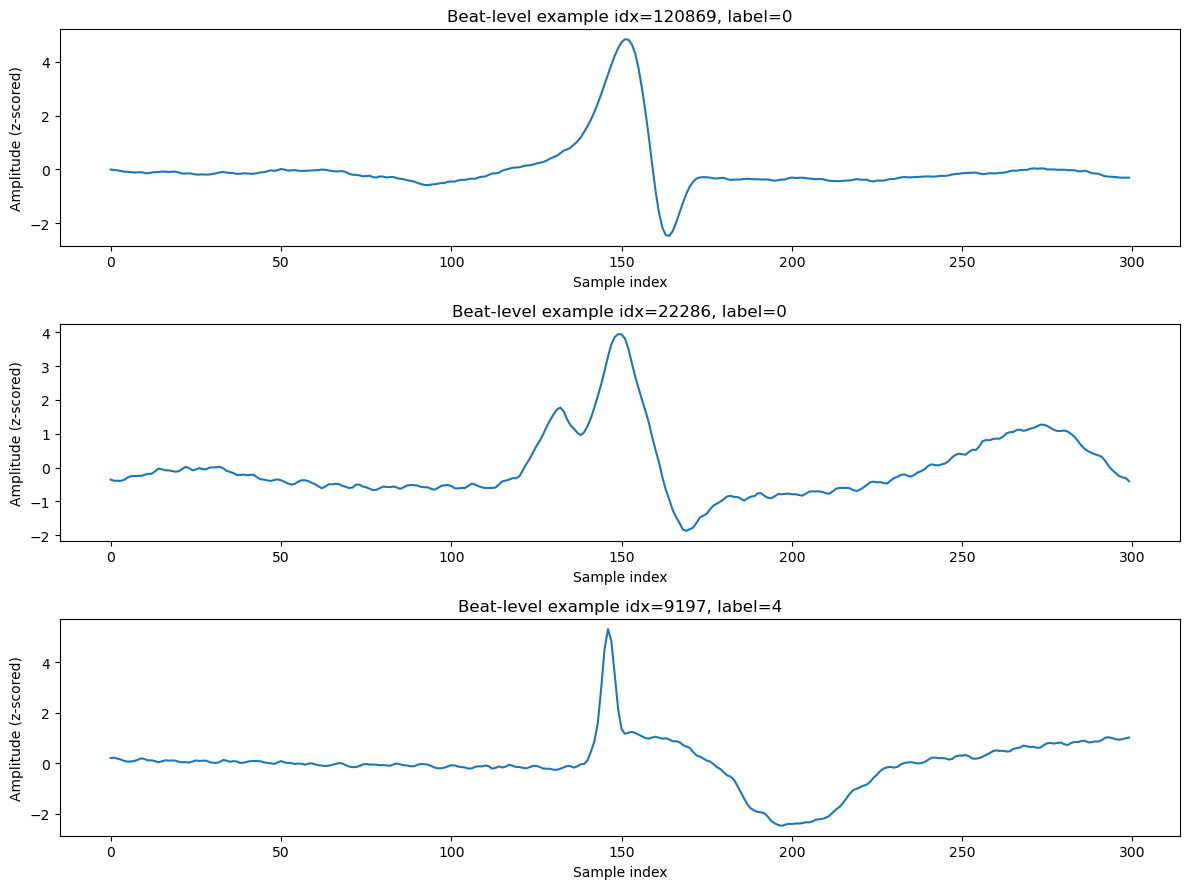

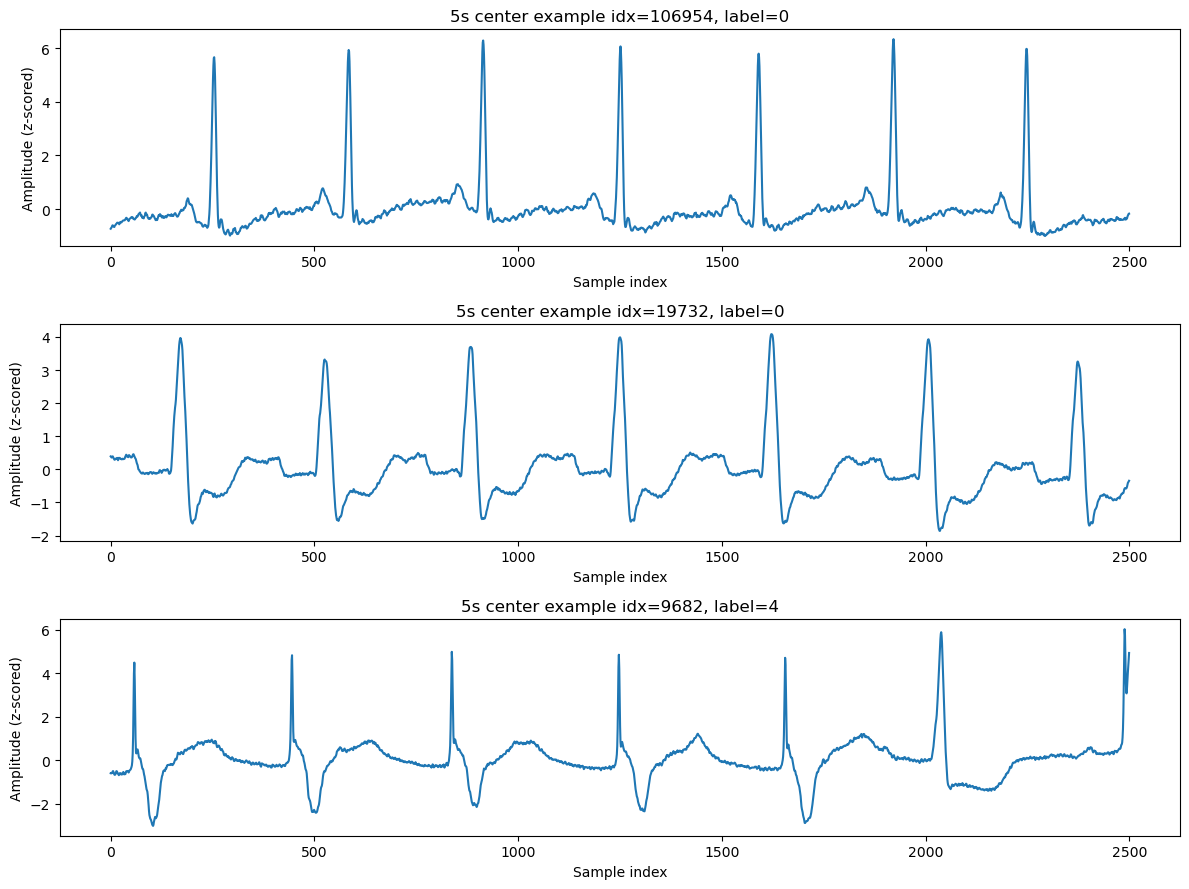

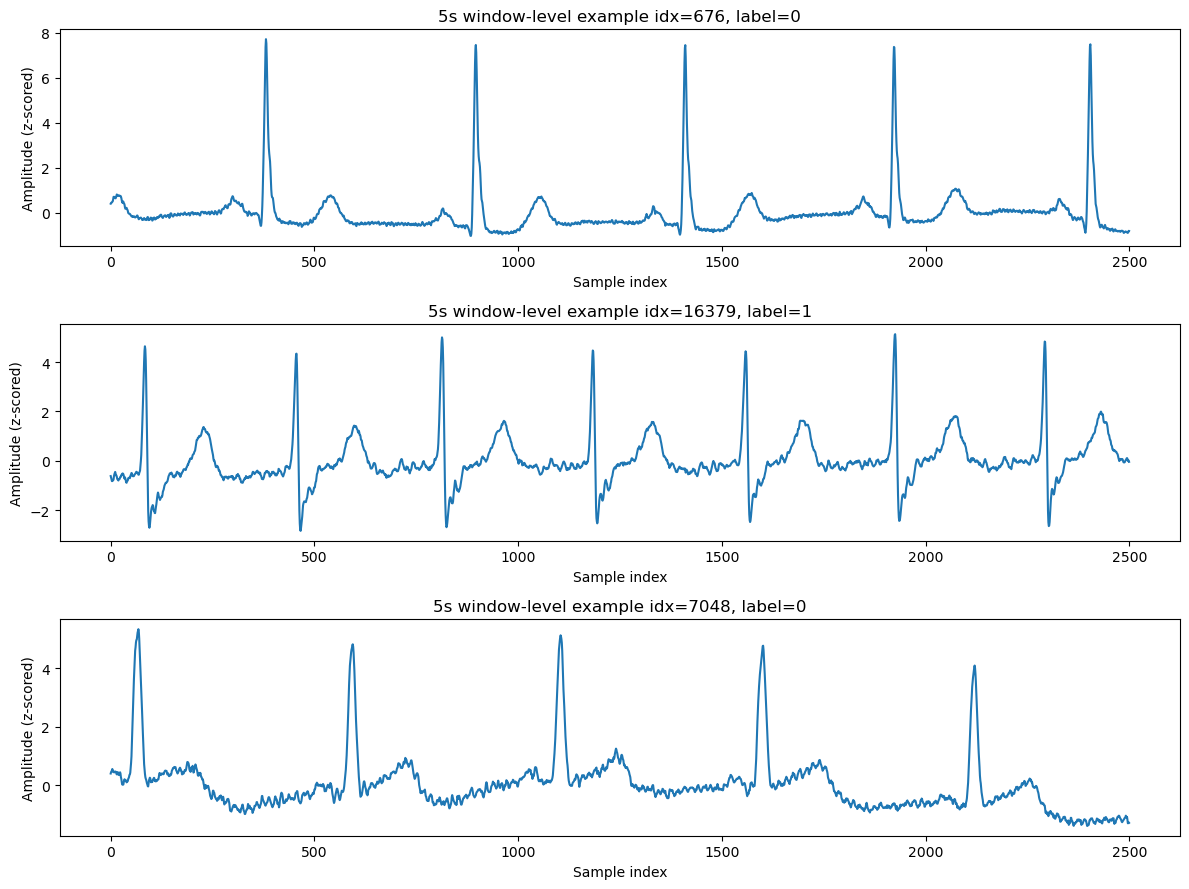

In [80]:
# Step 3 – Visual sanity check: plot random samples

import matplotlib.pyplot as plt
import random


def plot_random_examples(X: np.ndarray, y: np.ndarray, title: str, num=3):
    n = X.shape[0]
    idxs = random.sample(range(n), k=min(num, n))
    t = np.arange(X.shape[1])  # sample index; you can convert to seconds if needed

    plt.figure(figsize=(12, 3 * len(idxs)))
    for i, idx in enumerate(idxs, start=1):
        plt.subplot(len(idxs), 1, i)
        plt.plot(t, X[idx])
        plt.title(f"{title} example idx={idx}, label={y[idx]}")
        plt.xlabel("Sample index")
        plt.ylabel("Amplitude (z-scored)")
    plt.tight_layout()
    plt.show()


plot_random_examples(beat_X, beat_y, "Beat-level", num=3)
plot_random_examples(center_X, center_y, "5s center", num=3)
plot_random_examples(win_X, win_y, "5s window-level", num=3)

In [81]:
# Step 4 – Check z-score normalization


def check_zscore_stats(X: np.ndarray, name: str, num=1000):
    n = X.shape[0]
    k = min(num, n)
    idxs = np.random.choice(n, size=k, replace=False)

    means = X[idxs].mean(axis=1)
    stds = X[idxs].std(axis=1)

    print(f"\n{name} z-score stats on {k} samples:")
    print("  mean of means:     ", float(means.mean()))
    print("  std of means:      ", float(means.std()))
    print("  mean of stds:      ", float(stds.mean()))
    print("  std of stds:       ", float(stds.std()))
    print("  min/std/std range: ", float(stds.min()), float(stds.max()))


check_zscore_stats(beat_X, "Beat-level")
check_zscore_stats(center_X, "5s center")
check_zscore_stats(win_X, "5s window-level")


Beat-level z-score stats on 1000 samples:
  mean of means:      1.3128518716598592e-08
  std of means:       3.4740403975774825e-07
  mean of stds:       1.0
  std of stds:        4.77581636459945e-08
  min/std/std range:  0.9999998807907104 1.0000001192092896

5s center z-score stats on 1000 samples:
  mean of means:      -1.1868286797778183e-08
  std of means:       3.0095000624896784e-07
  mean of stds:       1.0
  std of stds:        4.392178709622385e-08
  min/std/std range:  0.9999998807907104 1.0000001192092896

5s window-level z-score stats on 1000 samples:
  mean of means:      1.831818252640005e-09
  std of means:       4.345002082573046e-07
  mean of stds:       1.0
  std of stds:        4.5899447798092297e-08
  min/std/std range:  0.9999998807907104 1.0000001192092896


In [82]:
# Step 5 – Size sanity: how many samples per dataset?

print("Sizes:")
print("  N_beat:   ", beat_X.shape[0])
print("  N_center: ", center_X.shape[0])
print("  N_win5s:  ", win_X.shape[0])

Sizes:
  N_beat:    124331
  N_center:  123932
  N_win5s:   20044


## Part 7: All databases

In [83]:
from pathlib import Path
import wfdb


def check_beat_annotation(db_dir: Path):
    print(f"\n=== Checking DB: {db_dir.name} ===")

    hea_files = sorted(db_dir.rglob("*.hea"))
    if not hea_files:
        print("No .hea files found.")
        return

    sampled = hea_files[:3]  # sample first 3 files to test
    found_any = False

    for hea in sampled:
        rec_path = hea.with_suffix("")
        try:
            ann = wfdb.rdann(str(rec_path), "atr")  # typical beat annotation
            print(f"{hea.name}: ann samples = {len(ann.sample)}")
            if len(ann.sample) > 0:
                found_any = True
        except Exception as e:
            print(f"{hea.name}: no beat annotation ({e})")

    if found_any:
        print("=> Beat-level annotation exists ✔")
    else:
        print("=> No beat-level annotation ✘")


DATA_ROOT = Path(r"..\data")

for db_name in [
    "afdb",
    "apnea",
    "edb",
    "fantasia",
    "incartdb",
    "ltafdb",
    "mitdb",
    "nsrdb",
    "ptbdb",
    "qtdb",
    "sddb",
]:
    check_beat_annotation(DATA_ROOT / db_name)


=== Checking DB: afdb ===
00735.hea: ann samples = 3
03665.hea: ann samples = 15
04015.hea: ann samples = 15
=> Beat-level annotation exists ✔

=== Checking DB: apnea ===
a01.hea: no beat annotation ([Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/apnea/a01.atr')
a01er.hea: no beat annotation ([Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/apnea/a01er.atr')
a01r.hea: no beat annotation ([Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/apnea/a01r.atr')
=> No beat-level annotation ✘

=== Checking DB: edb ===
e0103.hea: ann samples = 7336
e0104.hea: ann samples = 7824
e0105.hea: ann samples = 6704
=> Beat-level annotation exists ✔

=== Checking DB: fantasia ===
f1o01.hea: no beat annotation ([Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/fantasia/f1o01.atr')
f1o02.hea: n

In [84]:
from collections import Counter


def inspect_symbols_for_db(db_dir: Path, max_records: int = 3):
    print(f"\n=== Inspecting symbols in: {db_dir.name} ===")
    hea_files = sorted(db_dir.rglob("*.hea"))
    if not hea_files:
        print("  No .hea files.")
        return

    symbol_counter = Counter()

    for hea in hea_files[:max_records]:
        rec_path = hea.with_suffix("")
        try:
            ann = wfdb.rdann(str(rec_path), "atr")
        except Exception as e:
            print(f"  {hea.name}: failed to read ann ({e})")
            continue

        symbol_counter.update(ann.symbol)

    print("  Unique symbols (sampled):")
    for sym, cnt in symbol_counter.most_common():
        print(f"    '{sym}': {cnt}")

In [85]:
# DATA_ROOT = Path(r"..\data")

for db_name in ["mitdb", "incartdb", "qtdb", "nsrdb", "afdb", "ltafdb", "edb", "sddb"]:
    inspect_symbols_for_db(DATA_ROOT / db_name)


=== Inspecting symbols in: mitdb ===
  Unique symbols (sampled):
    'N': 4198
    '/': 2028
    'f': 56
    'A': 36
    '+': 7
    'V': 5
    '~': 4
    '|': 4
    'Q': 2

=== Inspecting symbols in: incartdb ===
  Unique symbols (sampled):
    'N': 7183
    'V': 698
    'A': 2

=== Inspecting symbols in: qtdb ===
  Unique symbols (sampled):
    'N': 2163
    '/': 1087
    'A': 19
    'V': 1
    '+': 1

=== Inspecting symbols in: nsrdb ===
  Unique symbols (sampled):
    'N': 277813
    '|': 7576
    '~': 2776
    'V': 16
    'S': 11
    'F': 6

=== Inspecting symbols in: afdb ===
  Unique symbols (sampled):
    '+': 33

=== Inspecting symbols in: ltafdb ===
  Unique symbols (sampled):
    'N': 269021
    'A': 7248
    '+': 4329
    'V': 1481
    '"': 33

=== Inspecting symbols in: edb ===
  Unique symbols (sampled):
    'N': 21509
    '~': 99
    'V': 92
    's': 66
    'T': 54
    '+': 19
    'S': 18
    '|': 5
    'F': 2

=== Inspecting symbols in: sddb ===
  Unique symbols (sample

这一张表已经决定了谁能加入 AAMI arrhythmia 下游任务

| DB           | 主要 symbol         | 阅后感                  | AAMI 分类核心地位   |
| ------------ | ----------------- | -------------------- | ------------- |
| **mitdb**    | N, A, V, F（都有）    | 全班最标准，必须用            | ⭐⭐⭐⭐⭐ 主力库     |
| **incartdb** | N, V, A           | 和 MIT-BIH 几乎一致，非常干净  | ⭐⭐⭐⭐ 重要补充     |
| **qtdb**     | N, 少量 A/V + `/`   | 可以补少量非 N 样本，但要过滤 `/` | ⭐⭐⭐ 补充用       |
| **nsrdb**    | 99.9% N           | 巨量 Normal 样本；平衡用宝藏库  | ⭐⭐⭐ 平衡 N 类    |
| **afdb**     | + only            | “+”代表节律注释，不是 beat 类别 | ✘ 不用于 beat 分类 |
| **ltafdb**   | N + A + V 可观数量    | 但任务偏 AF vs non-AF    | ⭐⚠️（可选，需规则过滤） |
| **edb**      | N/V/S/F + ST 特有符号 | ST-T episodes 任务为主   | ⭐⚠️ 限定使用      |
| **sddb**     | 大量 N, 很多 V/J/F    | 有 VT/VF 特征，可做高级任务    | ⭐⚠️ 需仔细清洗     |


FYP 下游 arrhythmia 分类的主力训练数据集，应锁定：

- MITDB
- INCARTDB
- QTDB
- NSRDB

- MITDB 的 `/` 常表示 “unknown / paced / artifact”，归入AAMI=Q
- QTDB 的 `/` 数量巨大，推测是 fusion 或 non-beat: 必须丢弃 `/` 和 `+` 才能获得干净的 AAMI 集合
- SDDB 有 `J` 表示结性逸搏: 往往归入 AAMI N 类
- EDB 有 `s`, `T` 等 ST changes: 不用于 AAMI 下游的主任务，但可用于 ST detection 子任务

所有 不在白名单中的 symbol -> 丢弃
比如：`+`, `/`, `|`, `~`, `'`, `s`, `T`, `J`, `a?`

如果我们严格白名单：

- MITDB：标签分布良好
- INCARTDB：N/V 主力，A 极少，F/Q 稀缺 → 仍然非常有价值
- QTDB：还可以
- NSRDB：几乎全是 N → 理想的「类不平衡修复」资源

值得一提：

F 类 在所有数据集中都极其稀缺: 可考虑合并到 Q 类或重采样增强（你的 FYP 可选研究点）

In [86]:
for db_name in ["mitdb", "incartdb", "qtdb", "nsrdb"]:
    inspect_symbols_for_db(DATA_ROOT / db_name, max_records=-1)


=== Inspecting symbols in: mitdb ===
  Unique symbols (sampled):
    'N': 86340
    'L': 9616
    'R': 8264
    'V': 7892
    '/': 7028
    'A': 3064
    '+': 1472
    'f': 982
    'F': 825
    '~': 683
    '"': 607
    '!': 472
    'j': 235
    'x': 199
    '|': 162
    'a': 154
    'J': 113
    'E': 106
    'Q': 33
    'e': 21
    '[': 6
    ']': 6
    'S': 2

=== Inspecting symbols in: incartdb ===
  I38.hea: failed to read ann ([Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/incartdb/1.0.0/I38.atr')
  Unique symbols (sampled):
    'N': 146774
    'V': 18855
    'R': 3174
    'A': 1944
    'F': 212
    'j': 92
    'n': 32
    'S': 16
    '+': 12
    'Q': 5
    'B': 1

=== Inspecting symbols in: qtdb ===
  sel30.hea: failed to read ann ([Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel30.atr')
  sel31.hea: failed to read ann ([Errno 2] No such file or directory: 'g:/M

- mitdb: `N, A, V, F, /, +, f, Q, ~, |`:  AAMI 分类的“标准答案库”。
- incartdb: `N, V, A`:  N / V 为主，A 极少，但语义和 MIT-BIH 很接近，很适合作为 第二个主力库。
- qtdb: `N, /, A, V, +`:  也有 N / A / V，但 / 和 + 很多，需要考虑是否丢弃这些 “非 beat 符号”。
- nsrdb: `N, |, ~, V, S, F`:  基本全是 N，少量 V / S / F，补 N 类样本非常强。

In [87]:
# label_mapping.py

from typing import Dict

AAMI_CLASSES = ["N", "S", "V", "F", "Q"]
AAMI_TO_INDEX: Dict[str, int] = {c: i for i, c in enumerate(AAMI_CLASSES)}


def aami_to_index(aami: str) -> int:
    return AAMI_TO_INDEX[aami]


# Base symbol->AAMI mapping shared by MITDB-like databases.
# This is deliberately "loose" and can be refined later.
BASE_SYMBOL_TO_AAMI: Dict[str, str] = {
    # Normal-ish beats -> N
    "N": "N",
    "L": "N",
    "R": "N",
    "j": "N",
    "J": "N",
    # Supraventricular / atrial beats -> S
    "A": "S",
    "a": "S",
    "S": "S",
    # Ventricular beats -> V
    "V": "V",
    "E": "V",
    # Fusion beats -> F
    "F": "F",
    # Unknown / paced / artifact -> Q
    "/": "Q",
    "Q": "Q",
    # You can add more symbols later based on papers / PhysioNet docs
}

In [88]:
def map_symbol_to_aami(
    db_name: str,
    symbol: str,
    mode: str = "loose",
) -> str | None:
    """
    Map a beat symbol from a given DB to an AAMI superclass.

    Args:
        db_name: 'mitdb', 'incartdb', 'qtdb', 'nsrdb', ...
        symbol: raw annotation symbol from wfdb.rdann
        mode:
            - 'loose': map as many symbols as possible; unknown symbols -> 'Q'
            - 'strict': only map symbols in BASE_SYMBOL_TO_AAMI; others -> None

    Returns:
        'N'/'S'/'V'/'F'/'Q' or None (ignored)
    """

    # 1) First handle non-beat markers that we usually want to ignore
    #    These appear a lot in all databases.
    if symbol in {"+", "|", "~"}:
        # Non-beat timing markers, we ignore them in both modes.
        return None

    # 2) Shared mapping
    if symbol in BASE_SYMBOL_TO_AAMI:
        return BASE_SYMBOL_TO_AAMI[symbol]

    # 3) DB-specific extras (you can refine later if needed)
    if db_name == "nsrdb":
        # In nsrdb, 'S'/'F' appear but very rarely; we can reuse BASE rules
        if symbol in {"S", "F"}:
            return BASE_SYMBOL_TO_AAMI.get(symbol, None)

    if db_name == "qtdb":
        # '/' is already mapped to 'Q' in BASE; '+' is ignored above
        pass

    if db_name == "sddb":
        # 'J' often treated as N-class; already in BASE as N
        # 'E' treated as V-class; already in BASE as V
        pass

    # 4) Mode-specific behavior for unknown symbols
    if mode == "loose":
        # In loose mode, unknown beat-like symbols can be mapped to Q
        # Instead of dropping them; this lets you keep more data.
        return "Q"
    else:
        # strict mode: unknown symbols are dropped
        return None

In [89]:
# --------------------
# Global config (you can also pass these as function args)
# --------------------
TARGET_FS = 500  # must match FM pretraining if you want to reuse encoder
BEAT_SEC = 0.6  # length of single beat segment in seconds
WIN_SEC = 5.0  # 5s windows
WIN_STRIDE_SEC = 5.0  # non-overlapping windows by default


# Lead selection preferences per DB (single-lead)
# Adjust if needed based on your earlier inspection.
LEAD_PREFERENCE = {
    "mitdb": ["MLII", "II", "V1", "V5"],
    "incartdb": ["I", "II", "MLII"],
    "qtdb": ["MLII", "II", "V5", "V2"],
    "nsrdb": ["ECG1", "ECG2"],
}


def pick_single_lead(db_name: str, rec: wfdb.Record) -> np.ndarray:
    """
    Select a single lead from a multi-lead ECG record.

    Returns:
        1D signal of shape [T]
    """
    sig = rec.p_signal  # [T, n_sig] or [T]
    sig_names = getattr(rec, "sig_name", None)
    n_sig = getattr(rec, "n_sig", sig.shape[1] if sig.ndim == 2 else 1)

    # Single-channel case: just return it
    if sig.ndim == 1 or n_sig == 1:
        return sig.astype(np.float32).reshape(-1)

    prefs = LEAD_PREFERENCE.get(db_name, None)
    if prefs is not None and sig_names is not None:
        name_to_idx = {name: idx for idx, name in enumerate(sig_names)}
        for pref in prefs:
            if pref in name_to_idx:
                idx = name_to_idx[pref]
                return sig[:, name_to_idx[pref]].astype(np.float32).reshape(-1)

    # Fallback: first channel
    print(f"[WARN] {db_name}: using channel 0 as fallback, sig_names={sig_names}")
    return sig[:, 0].astype(np.float32).reshape(-1)


def read_record_and_annotations(
    db_name: str,
    rec_path: Path,
) -> Tuple[np.ndarray, int, np.ndarray, List[str]]:
    """
    Read single-lead signal + beat annotations for a record.

    Returns:
        sig_res: 1D float32 array at TARGET_FS
        fs_target: int, TARGET_FS
        ann_res: np.ndarray of resampled beat positions (indices in sig_res)
        symbols: list of raw beat symbols
    """
    # Read raw record
    rec = wfdb.rdrecord(str(rec_path))
    sig_1d = pick_single_lead(db_name, rec)
    fs_orig = int(rec.fs)

    # Read annotations (.atr)
    ann = wfdb.rdann(str(rec_path), "atr")
    ann_samples = ann.sample.astype(int)
    symbols = list(ann.symbol)

    # Resample signal
    sig_res = resample_signal(sig_1d, fs_orig, TARGET_FS)
    T_res = len(sig_res)

    # Map annotation positions to resampled indices
    factor = TARGET_FS / fs_orig
    ann_res = (ann_samples.astype(float) * factor).round().astype(int)
    ann_res = np.clip(ann_res, 0, T_res - 1)

    return sig_res, TARGET_FS, ann_res, symbols


# -------------------------------------------------------------------------
# Core builder: beat-level + 5s-center + 5s-window for a given DB
# -------------------------------------------------------------------------


def build_beat_center_window_for_db(
    db_name: str,
    db_dir: Path,
    out_dir: Path,
    target_fs: int = TARGET_FS,
    beat_sec: float = BEAT_SEC,
    win_sec: float = WIN_SEC,
    win_stride_sec: float = WIN_STRIDE_SEC,
    mode: str = "loose",
    max_beats: int | None = None,
    max_center: int | None = None,
    max_win: int | None = None,
) -> None:
    """
    Build three downstream datasets (beat-level, 5s center, 5s window-level)
    for a single database.

    max_beats / max_center / max_win:
        Optional global caps on dataset size to avoid huge memory usage.
        If None, no explicit cap (use with caution for very large DBs).
    """
    out_dir.mkdir(parents=True, exist_ok=True)

    hea_files = sorted(db_dir.rglob("*.hea"))
    if not hea_files:
        raise FileNotFoundError(f"No .hea files found in {db_dir}")

    print(f"\n=== Building downstream datasets for DB: {db_name} ===")
    print("Total .hea files:", len(hea_files))
    print("Mode:", mode)

    # --------------------
    # Pre-computed lengths
    # --------------------
    beat_half_len = int(target_fs * beat_sec / 2.0)
    beat_len = beat_half_len * 2

    win_len = int(target_fs * win_sec)
    win_half_len = win_len // 2
    win_stride = int(target_fs * win_stride_sec)

    # --------------------
    # Storage
    # --------------------
    beat_segments: List[np.ndarray] = []
    beat_labels: List[int] = []

    center_segments: List[np.ndarray] = []
    center_labels: List[int] = []

    win_segments: List[np.ndarray] = []
    win_labels: List[int] = []

    # --------------------
    # Main loop over records
    # --------------------
    for hea in tqdm(hea_files, desc=f"{db_name}"):
        rec_path = hea.with_suffix("")

        try:
            sig_res, fs_res, ann_res, symbols = read_record_and_annotations(
                db_name, rec_path
            )
        except Exception as e:
            print(f"[WARN] Failed to read {rec_path}: {e}")
            continue

        T_res = len(sig_res)

        # -------------------------------------------------------------
        # Beat-level + 5s center: iterate over each beat
        # -------------------------------------------------------------
        for sample_idx, sym in zip(ann_res, symbols):
            # If we already reached the caps, we can optionally break early
            if (
                max_beats is not None
                and len(beat_segments) >= max_beats
                and max_center is not None
                and len(center_segments) >= max_center
            ):
                # Both caps reached: no need to process more beats
                break

            aami = map_symbol_to_aami(db_name, sym, mode=mode)
            if aami is None:
                continue

            label_idx = aami_to_index(aami)
            center = int(sample_idx)

            # Beat-level segment around the beat
            if max_beats is None or len(beat_segments) < max_beats:
                beat_start = center - beat_half_len
                beat_end = center + beat_half_len
                if 0 <= beat_start and beat_end <= T_res:
                    seg_beat = sig_res[beat_start:beat_end]
                    seg_beat = zscore_1d(seg_beat)
                    beat_segments.append(seg_beat)
                    beat_labels.append(label_idx)

            # 5s-center window around the beat
            if max_center is None or len(center_segments) < max_center:
                win_start = center - win_half_len
                win_end = center + win_half_len
                if 0 <= win_start and win_end <= T_res:
                    seg_center = sig_res[win_start:win_end]
                    seg_center = zscore_1d(seg_center)
                    center_segments.append(seg_center)
                    center_labels.append(label_idx)

        # -------------------------------------------------------------
        # 5s window-level: slide fixed windows + majority vote
        # -------------------------------------------------------------
        # Pre-collect all valid beats in this record with labels
        beat_positions: List[int] = []
        beat_labels_this_rec: List[int] = []

        for sample_idx, sym in zip(ann_res, symbols):
            aami = map_symbol_to_aami(db_name, sym, mode=mode)
            if aami is None:
                continue

            pos = int(sample_idx)
            if pos < 0 or pos >= T_res:
                continue

            beat_positions.append(pos)
            beat_labels_this_rec.append(aami_to_index(aami))

        if beat_positions:
            beat_positions_arr = np.array(beat_positions, dtype=int)
            beat_labels_arr = np.array(beat_labels_this_rec, dtype=int)

            from collections import Counter

            start = 0
            while start + win_len <= T_res:
                # Respect global cap
                if max_win is not None and len(win_segments) >= max_win:
                    break

                end = start + win_len
                mask = (beat_positions_arr >= start) & (beat_positions_arr < end)

                if not np.any(mask):
                    start += win_stride
                    continue

                labels_in_win = beat_labels_arr[mask]
                counter = Counter(labels_in_win.tolist())
                majority_label, _ = counter.most_common(1)[0]

                win_seg = sig_res[start:end]
                win_seg = zscore_1d(win_seg)

                win_segments.append(win_seg)
                win_labels.append(majority_label)

                start += win_stride

    # --------------------
    # Save all three datasets
    # --------------------
    def save_xy(prefix: str, X_list: List[np.ndarray], y_list: List[int]):
        if not X_list:
            print(f"[WARN] No samples collected for {db_name} {prefix}. Skipping save.")
            return
        X = np.stack(X_list, axis=0).astype(np.float32)
        y = np.array(y_list, dtype=np.int64)

        x_path = out_dir / f"{db_name}_{prefix}_X.npy"
        y_path = out_dir / f"{db_name}_{prefix}_y.npy"
        np.save(x_path, X)
        np.save(y_path, y)

        print(f"{prefix} dataset saved for {db_name}:")
        print("  X:", x_path, X.shape, X.dtype)
        print("  y:", y_path, y.shape, y.dtype)

    save_xy("beat", beat_segments, beat_labels)
    save_xy("center5s", center_segments, center_labels)
    save_xy("win5s", win_segments, win_labels)

In [90]:
DATA_ROOT = Path(r"..\data")  # TODO: change to your own root path

DBS_DOWNSTREAM = {
    "mitdb": DATA_ROOT / "mitdb",
    "incartdb": DATA_ROOT / "incartdb",
    "qtdb": DATA_ROOT / "qtdb",
    "nsrdb": DATA_ROOT / "nsrdb",
}

OUT_ROOT = DATA_ROOT / "downstream_multidb"
OUT_ROOT.mkdir(parents=True, exist_ok=True)

MODE = "loose"  # or "strict"

print("Building downstream datasets for multiple DBs...")
print("MODE:", MODE)

for db_name, db_dir in DBS_DOWNSTREAM.items():
    db_out = OUT_ROOT / db_name
    if db_name == "nsrdb":
        # nsrdb is huge and mostly N-class; we cap it heavily
        build_beat_center_window_for_db(
            db_name=db_name,
            db_dir=db_dir,
            out_dir=db_out,
            mode=MODE,
            max_beats=300_000,
            max_center=200_000,
            max_win=200_000,
        )
    else:
        # smaller DBs can be kept full
        build_beat_center_window_for_db(
            db_name=db_name,
            db_dir=db_dir,
            out_dir=db_out,
            mode=MODE,
            max_beats=None,
            max_center=None,
            max_win=None,
        )

print("All done.")

Building downstream datasets for multiple DBs...
MODE: loose

=== Building downstream datasets for DB: mitdb ===
Total .hea files: 71
Mode: loose


mitdb: 100%|██████████| 71/71 [00:10<00:00,  6.51it/s]


beat dataset saved for mitdb:
  X: ..\data\downstream_multidb\mitdb\mitdb_beat_X.npy (126838, 300) float32
  y: ..\data\downstream_multidb\mitdb\mitdb_beat_y.npy (126838,) int64
center5s dataset saved for mitdb:
  X: ..\data\downstream_multidb\mitdb\mitdb_center5s_X.npy (126438, 2500) float32
  y: ..\data\downstream_multidb\mitdb\mitdb_center5s_y.npy (126438,) int64
win5s dataset saved for mitdb:
  X: ..\data\downstream_multidb\mitdb\mitdb_win5s_X.npy (20088, 2500) float32
  y: ..\data\downstream_multidb\mitdb\mitdb_win5s_y.npy (20088,) int64

=== Building downstream datasets for DB: incartdb ===
Total .hea files: 75
Mode: loose


incartdb:  52%|█████▏    | 39/75 [00:24<00:32,  1.10it/s]

[WARN] Failed to read ..\data\incartdb\1.0.0\I38: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/incartdb/1.0.0/I38.atr'


incartdb: 100%|██████████| 75/75 [00:32<00:00,  2.31it/s]


beat dataset saved for incartdb:
  X: ..\data\downstream_multidb\incartdb\incartdb_beat_X.npy (173156, 300) float32
  y: ..\data\downstream_multidb\incartdb\incartdb_beat_y.npy (173156,) int64
center5s dataset saved for incartdb:
  X: ..\data\downstream_multidb\incartdb\incartdb_center5s_X.npy (172748, 2500) float32
  y: ..\data\downstream_multidb\incartdb\incartdb_center5s_y.npy (172748,) int64
win5s dataset saved for incartdb:
  X: ..\data\downstream_multidb\incartdb\incartdb_win5s_X.npy (26640, 2500) float32
  y: ..\data\downstream_multidb\incartdb\incartdb_win5s_y.npy (26640,) int64

=== Building downstream datasets for DB: qtdb ===
Total .hea files: 105
Mode: loose


qtdb:   9%|▊         | 9/105 [00:01<00:14,  6.45it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']


qtdb:  10%|█         | 11/105 [00:01<00:12,  7.53it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']


qtdb:  12%|█▏        | 13/105 [00:01<00:13,  6.59it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']


qtdb:  14%|█▍        | 15/105 [00:02<00:12,  6.96it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']


qtdb:  16%|█▌        | 17/105 [00:02<00:12,  7.00it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']


qtdb:  18%|█▊        | 19/105 [00:02<00:12,  6.69it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']


qtdb:  20%|██        | 21/105 [00:03<00:11,  7.11it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']


qtdb:  22%|██▏       | 23/105 [00:03<00:12,  6.72it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']


qtdb:  30%|███       | 32/105 [00:06<00:15,  4.58it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel30: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel30.atr'
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']


qtdb:  32%|███▏      | 34/105 [00:07<00:13,  5.24it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']


qtdb:  34%|███▍      | 36/105 [00:07<00:12,  5.50it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel31: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel31.atr'
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']


qtdb:  40%|████      | 42/105 [00:07<00:06, 10.46it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel32: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel32.atr'
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel33: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel33.atr'
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel34: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel34.atr'
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel35: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel35.atr'


qtdb:  44%|████▍     | 46/105 [00:08<00:04, 12.89it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel36: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel36.atr'
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel37: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel37.atr'
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel38: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel38.atr'
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel39: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel39.atr'


qtdb:  48%|████▊     | 50/105 [00:08<00:03, 14.91it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel40: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel40.atr'
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel41: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel41.atr'
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel42: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel42.atr'
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel43: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel43.atr'


qtdb:  50%|█████     | 53/105 [00:26<01:52,  2.16s/it]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel44: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel44.atr'
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel45: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel45.atr'
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel46: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel46.atr'


qtdb:  54%|█████▍    | 57/105 [00:26<00:48,  1.02s/it]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel47: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel47.atr'
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel48: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel48.atr'
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel49: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel49.atr'
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel50: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel50.atr'


qtdb:  56%|█████▌    | 59/105 [00:26<00:33,  1.38it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel51: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel51.atr'
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] Failed to read ..\data\qtdb\sel52: [Errno 2] No such file or directory: 'g:/My Drive/UCD_Lecture_Assignment_Lab/FYP/FYP/notebooks/../data/qtdb/sel52.atr'
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']


qtdb:  58%|█████▊    | 61/105 [00:26<00:24,  1.83it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']


qtdb:  61%|██████    | 64/105 [00:29<00:29,  1.41it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']


qtdb:  63%|██████▎   | 66/105 [00:30<00:19,  2.04it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']


qtdb:  65%|██████▍   | 68/105 [00:30<00:12,  2.91it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']


qtdb:  67%|██████▋   | 70/105 [00:30<00:09,  3.74it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']


qtdb:  69%|██████▊   | 72/105 [00:31<00:06,  5.00it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['ECG1', 'ECG2']
[WARN] qtdb: using channel 0 as fallback, sig_names=['D3', 'D4']


qtdb:  70%|███████   | 74/105 [00:31<00:05,  6.00it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['D3', 'V3']
[WARN] qtdb: using channel 0 as fallback, sig_names=['D3', 'V4']


qtdb:  72%|███████▏  | 76/105 [00:31<00:04,  6.35it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['V3', 'D3']
[WARN] qtdb: using channel 0 as fallback, sig_names=['D3', 'V4']


qtdb:  74%|███████▍  | 78/105 [00:31<00:03,  6.99it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['D3', 'V4']
[WARN] qtdb: using channel 0 as fallback, sig_names=['D3', 'V4']


qtdb:  75%|███████▌  | 79/105 [00:32<00:03,  6.83it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['V4', 'D3']
[WARN] qtdb: using channel 0 as fallback, sig_names=['V4', 'D3']


qtdb:  78%|███████▊  | 82/105 [00:32<00:03,  6.79it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['V4', 'D3']
[WARN] qtdb: using channel 0 as fallback, sig_names=['V4', 'D3']


qtdb:  81%|████████  | 85/105 [00:32<00:02,  7.28it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['V4', 'D3']
[WARN] qtdb: using channel 0 as fallback, sig_names=['D3', 'V3']


qtdb:  82%|████████▏ | 86/105 [00:33<00:02,  7.21it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['D3', 'V3']
[WARN] qtdb: using channel 0 as fallback, sig_names=['D3', 'V4']


qtdb:  84%|████████▍ | 88/105 [00:33<00:02,  7.00it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['V4', 'D3']
[WARN] qtdb: using channel 0 as fallback, sig_names=['V4', 'D3']


qtdb:  86%|████████▌ | 90/105 [00:33<00:02,  6.82it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['CM5', 'CC5']
[WARN] qtdb: using channel 0 as fallback, sig_names=['CM5', 'CC5']


qtdb:  88%|████████▊ | 92/105 [00:34<00:02,  5.97it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['CM5', 'CC5']


qtdb:  90%|████████▉ | 94/105 [00:34<00:01,  6.50it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['CM5', 'mod.V1']
[WARN] qtdb: using channel 0 as fallback, sig_names=['CM5', 'CC5']


qtdb:  91%|█████████▏| 96/105 [00:34<00:01,  6.38it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['CM5', 'CC5']
[WARN] qtdb: using channel 0 as fallback, sig_names=['CM5', 'CC5']


qtdb:  93%|█████████▎| 98/105 [00:35<00:01,  6.11it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['V1-V2', 'V4-V5']
[WARN] qtdb: using channel 0 as fallback, sig_names=['CM5', 'CM2']


qtdb:  95%|█████████▌| 100/105 [00:35<00:00,  6.40it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['CM2', 'ML5']
[WARN] qtdb: using channel 0 as fallback, sig_names=['CM5', 'ML5']


qtdb:  97%|█████████▋| 102/105 [00:35<00:00,  6.25it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['CM5', 'CM4']
[WARN] qtdb: using channel 0 as fallback, sig_names=['CM5', 'ML5']


qtdb: 100%|██████████| 105/105 [00:36<00:00,  6.75it/s]

[WARN] qtdb: using channel 0 as fallback, sig_names=['CM5', 'ML5']


qtdb: 100%|██████████| 105/105 [00:36<00:00,  2.91it/s]


beat dataset saved for qtdb:
  X: ..\data\downstream_multidb\qtdb\qtdb_beat_X.npy (87414, 300) float32
  y: ..\data\downstream_multidb\qtdb\qtdb_beat_y.npy (87414,) int64
center5s dataset saved for qtdb:
  X: ..\data\downstream_multidb\qtdb\qtdb_center5s_X.npy (86994, 2500) float32
  y: ..\data\downstream_multidb\qtdb\qtdb_center5s_y.npy (86994,) int64
win5s dataset saved for qtdb:
  X: ..\data\downstream_multidb\qtdb\qtdb_win5s_X.npy (14731, 2500) float32
  y: ..\data\downstream_multidb\qtdb\qtdb_win5s_y.npy (14731,) int64

=== Building downstream datasets for DB: nsrdb ===
Total .hea files: 18
Mode: loose


nsrdb: 100%|██████████| 18/18 [01:20<00:00,  4.46s/it]


beat dataset saved for nsrdb:
  X: ..\data\downstream_multidb\nsrdb\nsrdb_beat_X.npy (300000, 300) float32
  y: ..\data\downstream_multidb\nsrdb\nsrdb_beat_y.npy (300000,) int64
center5s dataset saved for nsrdb:
  X: ..\data\downstream_multidb\nsrdb\nsrdb_center5s_X.npy (200000, 2500) float32
  y: ..\data\downstream_multidb\nsrdb\nsrdb_center5s_y.npy (200000,) int64
win5s dataset saved for nsrdb:
  X: ..\data\downstream_multidb\nsrdb\nsrdb_win5s_X.npy (200000, 2500) float32
  y: ..\data\downstream_multidb\nsrdb\nsrdb_win5s_y.npy (200000,) int64
All done.
